In [3]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import filters, exposure

cropped_dir = r"C:\Users\nagal\anaconda3\PA2\Cropped"


In [5]:
# Function to convert image to grayscale and compute the edge angle
def compute_edge_histogram(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image_np = np.array(image)

    # Sobel filter to calculate gradient in horizontal and vertical directions
    sobel_h = filters.sobel_h(image_np)
    sobel_v = filters.sobel_v(image_np)

    # Compute the angle of the gradient
    angle = np.mod(np.arctan2(sobel_v, sobel_h), np.pi)

    # Compute the histogram (36 bins)
    hist, hist_centers = exposure.histogram(angle, nbins=36)
    
    return hist, hist_centers

In [7]:
class_folders = ["n02088094-Afghan_hound", "n02093428-American_Staffordshire_terrier", "n02110627-affenpinscher", "n02116738-African_hunting_dog"]
class_labels = {"n02088094-Afghan_hound": 0,"n02093428-American_Staffordshire_terrier":1,"n02110627-affenpinscher":2,"n02116738-African_hunting_dog":3}

histograms = []
image_paths = []
dog=[]
for class_folder in class_folders:
    folder_path = os.path.join(cropped_dir, class_folder)
    image_files = os.listdir(folder_path)
    
    for image_file in image_files:
        # Pick the first image in the class
        image_path = os.path.join(folder_path, image_file)
        image_paths.append(image_path)

        # Compute the edge histogram
        hist, hist_centers = compute_edge_histogram(image_path)
        histograms.append(hist)
        dog.append(class_labels[class_folder])

In [8]:
hist=np.array(histograms)
dogs=np.array(dog)

In [11]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(hist, dogs, test_size=0.2,stratify=dogs, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [13]:
X_test_scaled = scaler.transform(X_test)

## Assigned classifiers 
##### Naive Bayes 
##### Decision Tree
##### Adaboost Classifier

In [15]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.model_selection import StratifiedKFold , cross_val_score,KFold
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix,ConfusionMatrixDisplay

classifiers=[GaussianNB(),DecisionTreeClassifier(max_depth=10),AdaBoostClassifier()]
def model_selection(clf):
    stfold =StratifiedKFold(n_splits=5)
    original,predicted,cm,val_accuracy=[],[],[],[]
    for train, test in stfold.split(X_train_scaled, y_train):
        xtrain, xval = X_train_scaled[train], X_train_scaled[test]
        ytrain, yval = y_train[train], y_train[test]
        
        clf.fit(xtrain, ytrain)
        pred= clf.predict(xval)
        original.extend(yval)
        predicted.extend(pred)
        
        val_acc = accuracy_score(yval, pred)
        val_accuracy.append(val_acc)
        
    print("mean validation accuracy: "+str(np.mean(val_accuracy)))
    
    test_acc = accuracy_score(y_test, clf.predict(X_test_scaled))
    print("test accuracy : "+str(test_acc))

    f1score = f1_score(y_test, clf.predict(X_test_scaled), average='weighted')
    print("f1 score : "+str(f1score))
    
    
    cm.append(confusion_matrix(y_test, clf.predict(X_test_scaled)))
    cm_display = ConfusionMatrixDisplay(confusion_matrix = sum(cm)/len(cm), display_labels =class_folders)
    cm_display.plot(xticks_rotation=45)
    plt.show() 

Gaussian NB
mean validation accuracy: 0.3803030303030303
test accuracy : 0.3515151515151515
f1 score : 0.34612416247989747


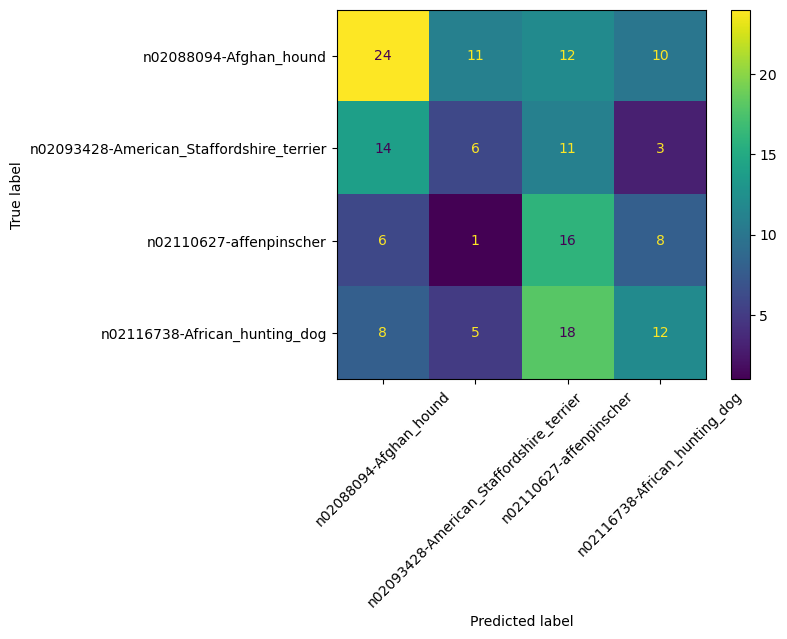

In [17]:
print("Gaussian NB")
model_selection(classifiers[0])

DecisionTreeClassifier(max_depth=10)
mean validation accuracy: 0.3363636363636363
test accuracy : 0.3212121212121212
f1 score : 0.32328702086706457


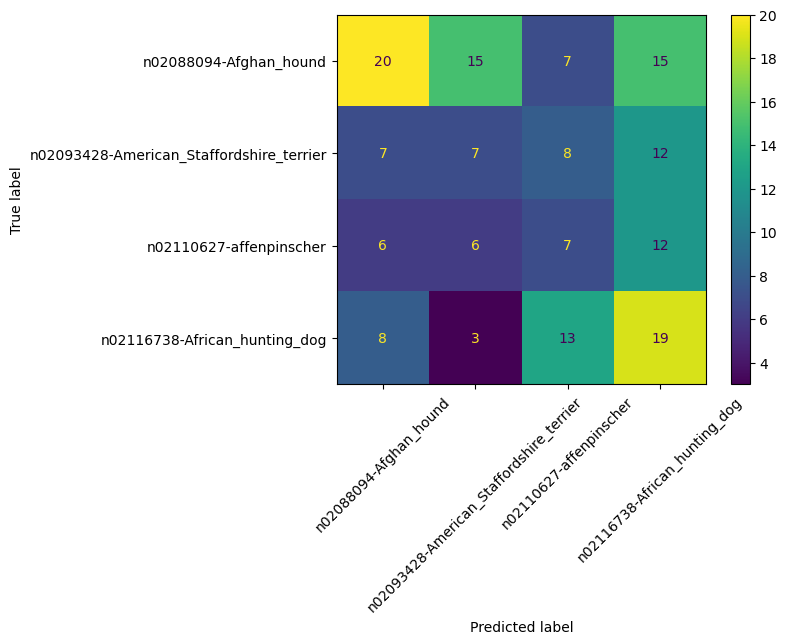

In [55]:
print("DecisionTreeClassifier(max_depth=10)")
model_selection(classifiers[1])

AdaBoostClassifier
mean validation accuracy: 0.40606060606060596
test accuracy : 0.34545454545454546
f1 score : 0.3457382499075289


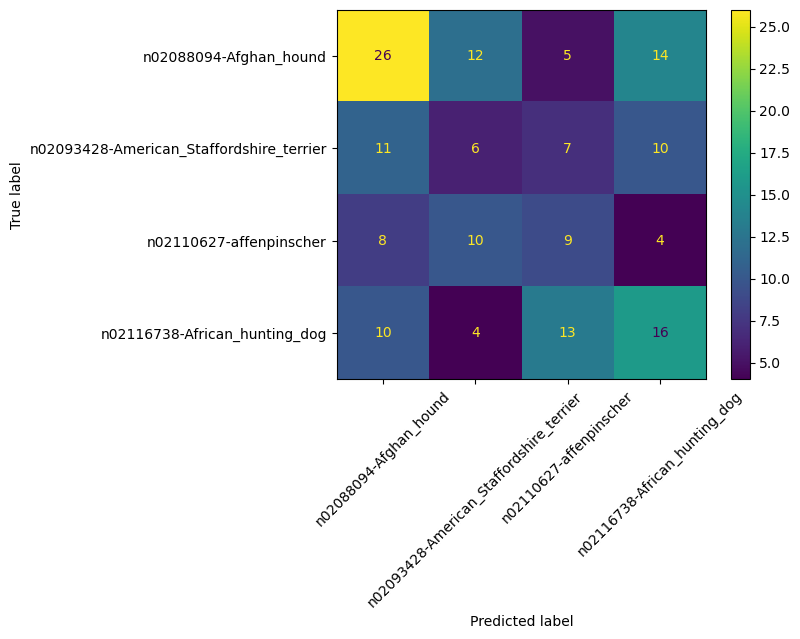

In [19]:
import warnings
warnings.filterwarnings("ignore")
print("AdaBoostClassifier")
model_selection(classifiers[2])

#### Based on Confusion matrix, we can see GaussianNB classifier diagonal values sum greater than other classifiers.
#### Based on the validation accuracies with 5 fold we see that Adaboost classifier is giving highest accuracy:0.40
#### Based on test accuracy , we can see GaussianNB is giving the highest accuracy of 0.35
#### Comparing the F1 scores of all three classifiers, which is combined results of precision and recall we can see that GaussianNB is again giving us better results

### From above observations we see that GaussianNB performs best 

In [21]:
histss=[]
dogss=[]
for class_folder in class_folders[:2]:
    folder_path = os.path.join(cropped_dir, class_folder)
    image_files = os.listdir(folder_path)
    
    for image_file in image_files:
        # Pick the first image in the class
        image_path = os.path.join(folder_path, image_file)
        image_paths.append(image_path)

        # Compute the edge histogram
        hist, hist_centers = compute_edge_histogram(image_path)
        histss.append(hist)
        dogss.append(class_labels[class_folder])

In [23]:
histss=np.array(histss)
dogss=np.array(dogss)

X_train, X_test, y_train, y_test = train_test_split(histss, dogss, test_size=0.2,stratify=dogss, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

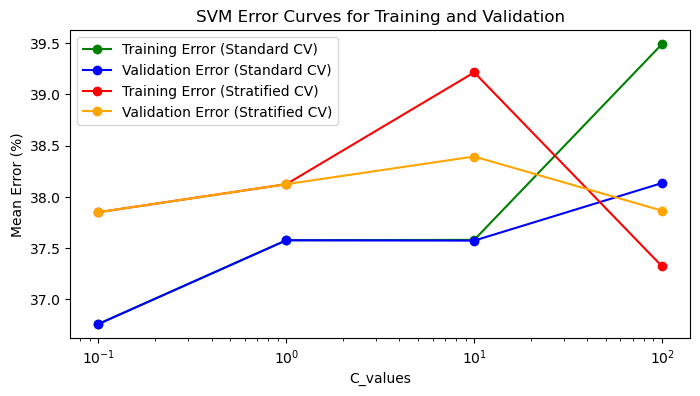

In [25]:
C_values = [0.1,1,10,100]

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.datasets import load_digits

# Arrays to store the errors for plotting
train_error_standard = []
val_error_standard = []
train_error_stratified = []
val_error_stratified = []

# Standard 5-Fold Cross-Validation
kf = KFold(n_splits=5)

# Stratified 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

# Iterate over each value of C
for c in C_values:
    # Create SVC model with specific C value
    svc = LinearSVC(C=c, max_iter=10000)

    # Perform standard 5-fold cross-validation for training and validation error
    val_scores_standard = cross_val_score(svc, X_train_scaled, y_train, cv=kf, scoring='accuracy')
    train_scores_standard = cross_val_score(svc, X_train_scaled, y_train, cv=kf, scoring='accuracy')
    
    # Perform stratified 5-fold cross-validation for training and validation error
    val_scores_stratified = cross_val_score(svc, X_train_scaled, y_train, cv=skf, scoring='accuracy')
    train_scores_stratified = cross_val_score(svc, X_train_scaled, y_train, cv=skf, scoring='accuracy')

    # Store mean training and validation errors
    train_error_standard.append(100 * (1 - np.mean(train_scores_standard)))
    val_error_standard.append(100 * (1 - np.mean(val_scores_standard)))
    train_error_stratified.append(100 * (1 - np.mean(train_scores_stratified)))
    val_error_stratified.append(100 * (1 - np.mean(val_scores_stratified)))

# Plotting the errors
plt.figure(figsize=(8, 4))
plt.plot(C_values, train_error_standard, label="Training Error (Standard CV)", marker='o', color='green')
plt.plot(C_values, val_error_standard, label="Validation Error (Standard CV)", marker='o', color='blue')
plt.plot(C_values, train_error_stratified, label="Training Error (Stratified CV)", marker='o', color='red')
plt.plot(C_values, val_error_stratified, label="Validation Error (Stratified CV)", marker='o', color='orange')

# Add labels, legend, and title
plt.xscale('log')
plt.xlabel('C_values')
plt.ylabel('Mean Error (%)')
plt.title('SVM Error Curves for Training and Validation')
plt.legend()
plt.show()


### The lowest mean error for standard Train at c=0.1 , stratified Train at c=100 , standard val at c=0.1, stratified val at c=100

### As 𝐶 increases, the validation errors differ significantly depending on the cross-validation method:
### Standard CV validation error (blue) increases sharply, indicating potential overfitting.
### Stratified CV validation error (orange) decreases, suggesting stratified CV provides more stable validation error with larger 𝐶.

### For standard C (like 0.1), the model has reduced complexity testing error is high while training error is low,stratified C it shows the model has high complexity